UEP run but using the negative of the LEP optimized point. As such, this notebook both,
1. Analyzes results
2. Creates starting position

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import pickle
from scipy import stats

In [2]:
from generate_opt_objects import A_b_generation

**PNC:/Users/mikestanley/anaconda3/envs/mc_sampling/lib/python3.8/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  pyproj could not be found, so IO/API coordinates cannot be converted to lat/lon; to fix, install pyproj or basemap (e.g., `pip install pyproj)`


In [3]:
# results base directory
BASE_DIR = './data/carbon_flux/results'

# save filepath
SAVE_FIG_BASE = '../figures/interval_optimizations/continental_US_jun2010/dual/11'

In [4]:
# paths
OBS_FP = '../fixed_optimization_inputs/y_affine_corrected.npy'

In [5]:
# get necessary objects
with open(OBS_FP, 'rb') as f:
    y_obs = np.load(f)
    
# gosat data
with open('../fixed_optimization_inputs/gosat_df_jan1_aug31_2010.csv', 'rb') as f:
    gosat_df = pd.read_csv(f)
L_inv_vec = 1 / gosat_df.xco2_unc.values
    
# tranform the data
y_tilde = np.multiply(L_inv_vec, y_obs)

CONSTR_DIR = '/Users/mikestanley/Research/Carbon_Flux/optimization/data/sign_corrected'
A, b = A_b_generation(
    box_constraint_fp=CONSTR_DIR + '/scipy_bnds.pkl'
)

FUNC_FP = '/Users/mikestanley/Research/Carbon_Flux/optimization'
FUNC_FP += '/src_admm/data/carbon_flux/objects/na_june_functional.npy'
with open(FUNC_FP, 'rb') as f:
    h = np.load(f)

In [6]:
# psi_alpha
with open('./data/carbon_flux/objects/opt_res_cont.pkl', 'rb') as f:
    opt_slack = pickle.load(f)
    
PSI_ALPHA = np.sqrt(stats.chi2.ppf(q=.95, df=1) + opt_slack[1])

In [7]:
def f_w(w, y=y_tilde, psi_alpha=PSI_ALPHA, b=b, c=np.zeros_like(b)):
    """ Lower endpoint functional """
    return np.dot(w, y) - psi_alpha * np.linalg.norm(w) - np.dot(b, c)

def f_w_uep(w, y=y_tilde, psi_alpha=PSI_ALPHA, b=b, c=np.zeros_like(b)):
    """ Lower endpoint functional """
    return -np.dot(w, y) + psi_alpha * np.linalg.norm(w) + np.dot(b, c)

# Plotting Functions

In [8]:
def global_avg_plot(w_ser, title_str=None, figsize=(8, 5)):
    """
    Globally averaged weights at daily, weekly, and month res
    
    Parameters
    ----------
        w_ser (pandas series) : weights indexed by time
    """
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize)
    ts_day = w_ser.resample('D').mean()
    ts_week = w_ser.resample('W').mean()
    ts_month = w_ser.resample('M').mean()
    ts_day.plot(ax=ax, label='Day')
    ts_week.plot(ax=ax, label='Week')
    ts_month.plot(ax=ax, label='Month')
    ax.axhline(0, linestyle='--', color='gray')
    ax.legend()
    ax.set_title(title_str)
    plt.show()
    
def month_map_plot(df, w_col_str, norm, vmin=None, vmax=None, figsize=(12, 16), save_fp=None):
    """
    Monthly heat maps for the given weights
    
    Parameters
    ----------
        df        (pandas dataframe)  : contains columns - 'month', 'lon', 'lat', and w_col_str
        w_col_str (str)               : name of w column in df to use
        norm      (mcolors.Normalize) : for color scheme
    """
    # w start
    fig, ax = plt.subplots(ncols=2, nrows=4, figsize=figsize)
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

    for i in range(8):
        row_idx = i // 2
        col_idx = i % 2
        month_idxs = df['month'].astype(int) == i + 1
        sp_i = ax[row_idx, col_idx].scatter(
            df['lon'][month_idxs], df['lat'][month_idxs],
            c=df[w_col_str][month_idxs],
            norm=norm, vmin=vmin, vmax=vmax,
            s=14, cmap='seismic'
        )
        ax[row_idx, col_idx].set_title(months[i])

    plt.colorbar(sp_i,ax=ax[0, 0])
    if save_fp:
        plt.savefig(save_fp, dpi=300)
        plt.close()
    else:
        plt.show()

# Optimization diagnostics

#### Convergence Plots

In [10]:
# read in the raw stdout file
with open(BASE_DIR + '/11/stdout_from_lep08.txt', 'r') as f:
    stdout0_raw = f.readlines()

In [15]:
# isolate the trajectories from the w optimization
all_obj_vals = [float(line[22:34].replace('D', 'e')) for line in stdout0_raw if 'At iterate' in line]
traj_w_01 = all_obj_vals[:4]
traj_c_01 = all_obj_vals[4:7]
traj_w_02 = all_obj_vals[7:8]
traj_c_02 = all_obj_vals[8:]

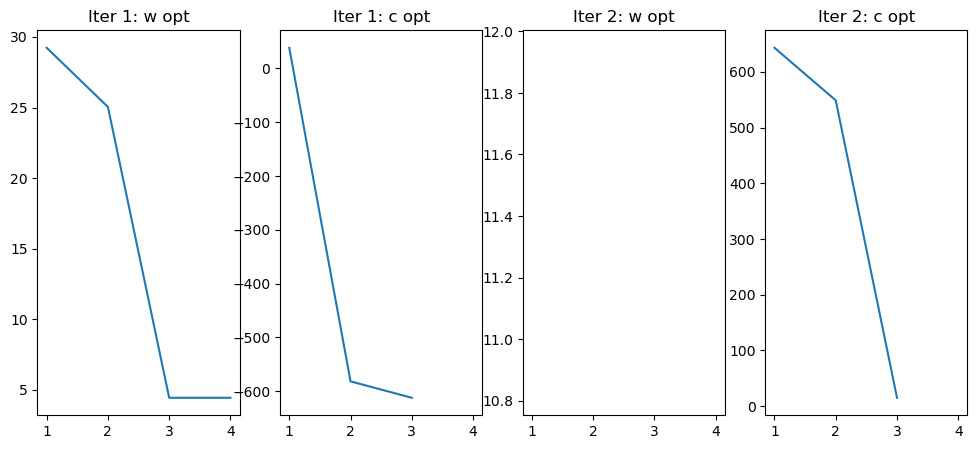

In [16]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(12, 5), sharex=True)

# iteration 1
ax[0].plot(np.arange(1, len(traj_w_01) + 1), traj_w_01)
ax[1].plot(np.arange(1, len(traj_c_01) + 1), traj_c_01)

# # iteration 2
ax[2].plot(np.arange(1, len(traj_w_02) + 1), traj_w_02)
ax[3].plot(np.arange(1, len(traj_c_02) + 1), traj_c_02)


# labels
ax[0].set_title('Iter 1: w opt')
ax[1].set_title('Iter 1: c opt')
ax[2].set_title('Iter 2: w opt')
ax[3].set_title('Iter 2: c opt')

plt.show()

#### Final Results

In [13]:
with open(BASE_DIR + '/11/final_results.pkl', 'rb') as f:
    final_res = pickle.load(f)
    
print(final_res)

{'objective_evals': [-625.4687056157022, 0.1300842893311588], 'w_opt_output': {'vectors': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -5.20509415e-05, -7.72026359e-05, -3.19461194e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -5.20509415e-05, -7.72026359e-05, -3.19461194e-03]]), 'status': array([1., 0.]), 'nfev': array([17., 11.]), 'njev': array([0., 0.])}, 'c_opt_output': {'vectors': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'status': array([1., 1.]), 'nfev': array([3., 4.]), 'njev': array([0., 0.])}, 'lambda_opt_output': {'vectors': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])}, 'KTw_vecs': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])}


In [17]:
# get feasibility values for other iterations
IDX = 2
feasibility_11 = np.zeros(IDX)
for i in range(0, IDX):
    feasibility_11[i] = np.linalg.norm(h + A.T @ final_res['c_opt_output']['vectors'][i] - final_res['KTw_vecs'][i])
    
print(feasibility_11)

[1.1376822  0.19972542]


# Weights plots

# Starting positions

In [10]:
# read in the ending points from LEP 08
with open(BASE_DIR + '/08/final_results.pkl', 'rb') as f:
    final_res_08 = pickle.load(f)

In [14]:
# save the new points to a new iteration 11
SAVE_BASE_SP = './data/carbon_flux/results/11/intermediate_starts'
with open(SAVE_BASE_SP + '/w_start_from_neg_lep08.npy', 'wb') as f:
    np.save(file=f, arr=-final_res_08['w_opt_output']['vectors'][-1])
    
# saving c starting position
with open(SAVE_BASE_SP + '/c_start_from_neg_lep08.npy', 'wb') as f:
    np.save(file=f, arr=final_res_08['c_opt_output']['vectors'][-1])
    
# saving lambda starting position
with open(SAVE_BASE_SP + '/lambda_start_from_neg_lep08.npy', 'wb') as f:
    np.save(file=f, arr=final_res_08['lambda_opt_output']['vectors'][-1])

#### From first two iterations

In [19]:
# save the new points to a new iteration 11
SAVE_BASE_SP = './data/carbon_flux/results/11/intermediate_starts'
with open(SAVE_BASE_SP + '/w_start_from_it2.npy', 'wb') as f:
    np.save(file=f, arr=-final_res['w_opt_output']['vectors'][-1])
    
# saving c starting position
with open(SAVE_BASE_SP + '/c_start_from_it2.npy', 'wb') as f:
    np.save(file=f, arr=final_res['c_opt_output']['vectors'][-1])
    
# saving lambda starting position
with open(SAVE_BASE_SP + '/lambda_start_from_it2.npy', 'wb') as f:
    np.save(file=f, arr=final_res['lambda_opt_output']['vectors'][-1])